In [ ]:
# Install required packages. Use the following commands to install the anomaly detector SDK and required packages.
! pip install --upgrade azure-ai-anomalydetector
! pip install azure-storage-blob
! pip install azure-mgmt-storage

# Install optional packages to see interactive visualization in this Jupyter notebook.
! pip install plotly==5.5.0
! pip install notebook>=5.3 
! pip install ipywidgets>=7.5

In [1]:
import json
import os
import time
from datetime import datetime, timezone
import pandas as pd

from azure.ai.anomalydetector import AnomalyDetectorClient
from azure.core.credentials import AzureKeyCredential
from azure.core.exceptions import HttpResponseError
from azure.ai.anomalydetector.models import *

### Create an Anomaly Detector client

In [2]:
# The ENDPOINT should be like: https://mvad-sample.cognitiveservices.azure.com/anomalydetector/v1.1
ANOMALY_DETECTOR_ENDPOINT = "https://tettttt.cognitiveservices.azure.com/"
SUBSCRIPTION_KEY = "89cbc450cc4a4d0bbe2684915bf5e736"
ad_client = AnomalyDetectorClient(ANOMALY_DETECTOR_ENDPOINT, AzureKeyCredential(SUBSCRIPTION_KEY))

## 6. Train a model <a class="anchor" id="train"></a>

In [3]:
train_body = ModelInfo(
        # The data source should be the Blob URL, something like: https://mvaddataset.blob.core.windows.net/sample-multitable/sample_data_5_3000.csv
        data_source="https://mvaddataset.blob.core.windows.net/sample-onetable/sample_data_5_3000.csv",
        # start_time and end_time are optional. If you don't set them, the whole data will be used to train the model.
        start_time="2021-01-01T00:00:00Z",
        end_time="2021-01-02T09:00:00Z",
        # If your data is one CSV file, please set the dataSchema as `OneTable`, if your data is multiple CSV files in a folder, please set the dataSchema as `MultiTable`.
        data_schema="OneTable",
        # Use display_name to name your model.
        display_name="sample",
        # Sliding window size is optional. If you don't set it, the default value is 200.
        sliding_window=200,
        # align_policy is optional. If you don't set it, the default value is `AlignPolicy(align_mode=AlignMode.OUTER, fill_n_a_method=FillNAMethod.LINEAR, padding_value=0)`.
        align_policy=AlignPolicy(
            align_mode=AlignMode.OUTER,
            fill_n_a_method=FillNAMethod.LINEAR,
            padding_value=0,
        ),
    )

In [4]:
model = ad_client.train_multivariate_model(train_body)
model_id = model.model_id
print(f"Model is created with the modelId: {model_id}, please check the model status using next cell.😉")

Model is created with the modelId: d061a9e6-80ff-11ed-84b1-660ee88c55e6, please check the model status using next cell.😉


### Get model status 

In [5]:
#Option 1: Loop to get status until the model is ready.
model_status = ad_client.get_multivariate_model(model_id).model_info.status

while model_status != "READY" and model_status != "FAILED":
    print(f"Model is {model_status}, please wait for a while.")
    print(f"EpochId: {ad_client.get_multivariate_model(model_id).model_info.diagnostics_info.model_state.epoch_ids}")
    time.sleep(30)
    model_status = ad_client.get_multivariate_model(model_id).model_info.status

print(f"Model is {model_status}, epochId: {ad_client.get_multivariate_model(model_id).model_info.diagnostics_info.model_state.epoch_ids} ")

Model is CREATED, please wait for a while.
EpochId: []
Model is RUNNING, please wait for a while.
EpochId: [10]
Model is RUNNING, please wait for a while.
EpochId: [10, 20]
Model is RUNNING, please wait for a while.
EpochId: [10, 20, 30]
Model is RUNNING, please wait for a while.
EpochId: [10, 20, 30, 40, 50]
Model is RUNNING, please wait for a while.
EpochId: [10, 20, 30, 40, 50, 60]
Model is RUNNING, please wait for a while.
EpochId: [10, 20, 30, 40, 50, 60, 70, 80]
Model is RUNNING, please wait for a while.
EpochId: [10, 20, 30, 40, 50, 60, 70, 80, 90]
Model is READY, epochId: [10, 20, 30, 40, 50, 60, 70, 80, 90, 100] 


In [12]:
# Option 2: Get the status of the model manually.

model_status = ad_client.get_multivariate_model(model_id).model_info.status
print(f"Model status: {model_status}")

# Print the following line to get the epochId which could help you better know the status of model. There are 100 epochIds in total.
print(f"EpochId: {ad_client.get_multivariate_model(model_id).model_info.diagnostics_info.model_state}")

# Check error message if model status is ERROR/FAILED.
#ad_client.get_multivariate_model(model_id).model_info.errors[0].message

Model status: READY
EpochId: [10, 20, 30, 40, 50, 60, 70, 80, 90, 100]


## 7. Inference <a class="anchor" id="inference"></a>

There are two types of inference:
* Batch inference (asynchronous)
* Streaming inference (synchronous)

You could use the `Batch Inference API` for a long period of data validation or for a micro-batch task, which works in an asynchronous way together with the `Get Inference Results API`. If your case is more like real-time or near real-time, the `Streaming Inference API` might be a good choice for you since it will present the anomaly results immediately once you call this API and get every timestamp detected per call. 

### Trigger a batch inference

In [15]:
batch_inference_body = MultivariateBatchDetectionOptions(
        data_source="https://mvaddataset.blob.core.windows.net/sample-onetable/sample_data_5_3000.csv",
        # The topContributorCount specify how many contributed variables you care about in the results, from 1 to 50.
        top_contributor_count=10,
        start_time="2021-01-02T09:00:00Z",
        end_time="2021-01-03T00:00:00Z",
    )

In [16]:
results = ad_client.detect_multivariate_batch_anomaly(model_id, batch_inference_body)
result_id = results.result_id
print(f"A batch inference is triggered with the resultId: {result_id}, please get the detection results using the next cell.")

A batch inference is triggered with the resultId: 084c2c42-807d-11ed-a094-46b61874dd0d, please get the detection results using the next cell.


### Get batch inference results

☕️Inference process might
take several minutes (depending on the data size). Take a cup of coffee and come back then, and waiting for its status to be **READY**.

In [17]:
# Option 1: Loop to get status until the detection is done.
anomaly_results = ad_client.get_multivariate_batch_detection_result(result_id)

while anomaly_results.summary.status != "READY" and anomaly_results.summary.status != "FAILED":
    print(f"Batch inference status: {anomaly_results.summary.status}")
    time.sleep(10)
    anomaly_results = ad_client.get_multivariate_batch_detection_result(result_id)

print(f"Batch inference status: {anomaly_results.summary.status}")

anomaly_results_df = pd.DataFrame([{'timestamp': x['timestamp'], **x['value']} for x in anomaly_results.results])
anomaly_results_df

Batch inference status: READY


,timestamp,isAnomaly,severity,score,interpretation
0,2021-01-02T09:00:00Z,False,0.000000,0.422468,[]
1,2021-01-02T09:01:00Z,False,0.000000,0.248953,[]
2,2021-01-02T09:02:00Z,False,0.000000,0.327707,[]
3,2021-01-02T09:03:00Z,False,0.000000,0.370318,[]
4,2021-01-02T09:04:00Z,False,0.000000,0.307785,[]
...,...,...,...,...,...
896,2021-01-02T23:56:00Z,False,0.000000,0.251313,[]
897,2021-01-02T23:57:00Z,False,0.000000,0.338793,[]
898,2021-01-02T23:58:00Z,True,0.297003,0.510336,"[{'variable': 'series_1', 'contributionScore':..."
899,2021-01-02T23:59:00Z,False,0.000000,0.451405,[]


In [15]:
# Option 2: Get the status of the detection manually.
anomaly_results = ad_client.get_multivariate_batch_detection_result(result_id)
print(f"Batch inference status: {anomaly_results.summary.status}")

Batch inference status: READY


In [16]:
anomaly_results_df = pd.DataFrame([{'timestamp': x['timestamp'], **x['value']} for x in anomaly_results.results])
anomaly_results_df

,timestamp,isAnomaly,severity,score,interpretation
0,2021-01-02T09:00:00Z,False,0.000000,0.419382,[]
1,2021-01-02T09:01:00Z,False,0.000000,0.252619,[]
2,2021-01-02T09:02:00Z,False,0.000000,0.322591,[]
3,2021-01-02T09:03:00Z,False,0.000000,0.369014,[]
4,2021-01-02T09:04:00Z,False,0.000000,0.306100,[]
...,...,...,...,...,...
896,2021-01-02T23:56:00Z,False,0.000000,0.253038,[]
897,2021-01-02T23:57:00Z,False,0.000000,0.340814,[]
898,2021-01-02T23:58:00Z,True,0.296033,0.508668,"[{'variable': 'series_1', 'contributionScore':..."
899,2021-01-02T23:59:00Z,False,0.000000,0.454258,[]


### Streaming Inference

Every time you trigger a streaming inference, you will get one timestamp detected.

In [17]:
with open("../../sampledata/multivariate/5_3000.json", "r") as f:
    sample_input = json.load(f)

variables = []
for item in sample_input["variables"]:
    variables.append(
        VariableValues(
            variable=item["variable"],
            timestamps=item["timestamps"],
            values=item["values"],
        )
    )

last_inference_body = MultivariateLastDetectionOptions(
    variables=variables,
    top_contributor_count=10,
)

In [18]:
streaming_inference_results = ad_client.detect_multivariate_last_anomaly(model_id, last_inference_body)
streaming_inference_results

{'variableStates': [{'variable': 'series_0', 'filledNARatio': 0.0, 'effectiveCount': 1, 'firstTimestamp': '2021-01-03T01:59:00Z', 'lastTimestamp': '2021-01-03T01:59:00Z'}, {'variable': 'series_1', 'filledNARatio': 0.0, 'effectiveCount': 1, 'firstTimestamp': '2021-01-03T01:59:00Z', 'lastTimestamp': '2021-01-03T01:59:00Z'}, {'variable': 'series_2', 'filledNARatio': 0.0, 'effectiveCount': 1, 'firstTimestamp': '2021-01-03T01:59:00Z', 'lastTimestamp': '2021-01-03T01:59:00Z'}, {'variable': 'series_3', 'filledNARatio': 0.0, 'effectiveCount': 1, 'firstTimestamp': '2021-01-03T01:59:00Z', 'lastTimestamp': '2021-01-03T01:59:00Z'}, {'variable': 'series_4', 'filledNARatio': 0.0, 'effectiveCount': 1, 'firstTimestamp': '2021-01-03T01:59:00Z', 'lastTimestamp': '2021-01-03T01:59:00Z'}], 'results': [{'timestamp': '2021-01-03T01:59:00Z', 'value': {'isAnomaly': False, 'severity': 0.0, 'score': 0.2703796327114105, 'interpretation': []}, 'errors': []}]}

## 8. List models <a class="anchor" id="list"></a>
You could check the status of your model and your model list. The `currentCount` means how many model you've created in your Anomaly Detector resource, and the `maxCount` means the limitation of your model number in your Anomaly Detector resource.

In [19]:
models = list(ad_client.list_multivariate_models(skip=0,top=10))
models_df = pd.DataFrame([{'modelId': x['modelId'], **x['modelInfo']} for x in models])
models_df

,modelId,dataSource,dataSchema,startTime,endTime,displayName,slidingWindow,alignPolicy,status,errors,diagnosticsInfo
0,077fffcc-8042-11ed-a094-46b61874dd0d,https://mvaddataset.blob.core.windows.net/samp...,OneTable,2021-01-01T00:00:00Z,2021-01-02T09:00:00Z,sample,200,"{'alignMode': 'Outer', 'fillNAMethod': 'Linear...",READY,[],"{'modelState': {'epochIds': [10, 20, 30, 40, 5..."
1,0e95b9c6-801c-11ed-9600-46b61874dd0d,https://mvaddataset.blob.core.windows.net/samp...,OneTable,2021-01-01T00:00:00Z,2021-01-02T09:00:00Z,sample,200,"{'alignMode': 'Outer', 'fillNAMethod': 'Linear...",READY,[],"{'modelState': {'epochIds': [10, 20, 30, 40, 5..."
2,a374e39e-8014-11ed-81d0-c2c5096ea4c3,https://mvaddataset.blob.core.windows.net/samp...,OneTable,2021-01-02T00:00:00Z,2021-01-02T05:00:00Z,sample,200,"{'alignMode': 'Outer', 'fillNAMethod': 'Linear...",READY,[],"{'modelState': {'epochIds': [10, 20, 30, 40, 5..."
3,70b7b266-8013-11ed-9600-46b61874dd0d,https://mvaddataset.blob.core.windows.net/samp...,OneTable,2021-01-02T00:00:00Z,2021-01-02T05:00:00Z,sample,200,"{'alignMode': 'Outer', 'fillNAMethod': 'Linear...",READY,[],"{'modelState': {'epochIds': [10, 20, 30, 40, 5..."
4,f4e04f06-8001-11ed-84c9-c2c5096ea4c3,https://mvaddataset.blob.core.windows.net/samp...,OneTable,2021-01-02T00:00:00Z,2021-01-02T05:00:00Z,sample,200,"{'alignMode': 'Outer', 'fillNAMethod': 'Linear...",READY,[],"{'modelState': {'epochIds': [10, 20, 30, 40, 5..."


## 9. Delete model <a class="anchor" id="delete"></a>

In [ ]:
ad_client.delete_multivariate_model(model_id)

## 10. Visualization <a class="anchor" id="vis"></a>

In [20]:
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import numpy as np

raw_data=pd.read_csv('../../sampledata/multivariate/sample_data_5_3000.csv')
df_merge=pd.merge(anomaly_results_df,raw_data, on="timestamp")
df_merge

,timestamp,isAnomaly,severity,score,interpretation,series_0,series_1,series_2,series_3,series_4
0,2021-01-02T09:00:00Z,False,0.000000,0.419382,[],1.205363,-0.082452,-0.679936,-2.427059,-0.901315
1,2021-01-02T09:01:00Z,False,0.000000,0.252619,[],-0.832825,0.511269,0.781305,-0.978200,-0.583167
2,2021-01-02T09:02:00Z,False,0.000000,0.322591,[],1.017443,-0.090590,-0.332330,-2.185502,-0.549980
3,2021-01-02T09:03:00Z,False,0.000000,0.369014,[],0.340099,-1.288155,0.902764,-2.049652,-0.303337
4,2021-01-02T09:04:00Z,False,0.000000,0.306100,[],-0.445510,-1.082052,-0.691915,-1.140514,-1.181026
...,...,...,...,...,...,...,...,...,...,...
896,2021-01-02T23:56:00Z,False,0.000000,0.253038,[],-0.496276,-0.327522,-0.982608,-1.152828,0.732866
897,2021-01-02T23:57:00Z,False,0.000000,0.340814,[],0.833020,0.285757,-1.691492,-1.481046,0.214137
898,2021-01-02T23:58:00Z,True,0.296033,0.508668,"[{'variable': 'series_1', 'contributionScore':...",0.864732,2.680365,1.244429,0.827081,-1.171265
899,2021-01-02T23:59:00Z,False,0.000000,0.454258,[],-0.742697,-1.620215,-1.778069,-1.627223,0.172657


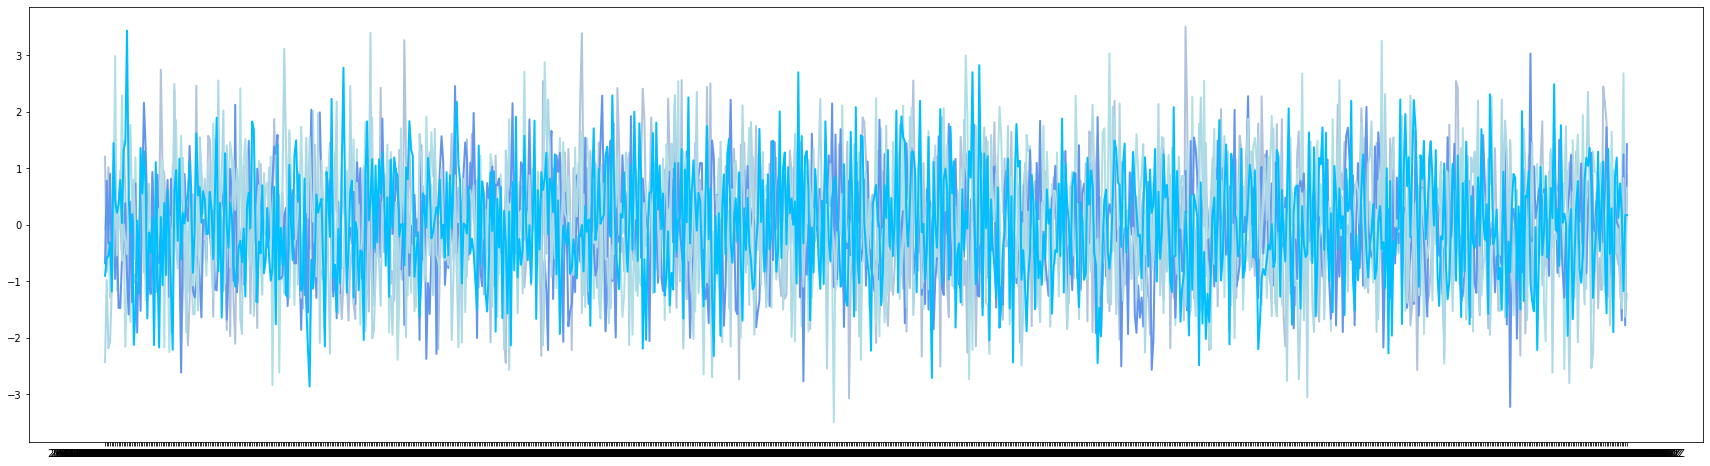

In [21]:
####### Main Figure #######
plt.figure(figsize=(30,8))
plt.plot(df_merge['timestamp'],df_merge['series_0'], color='lightsteelblue', linestyle='solid', linewidth=2, label='series_0')
plt.plot(df_merge['timestamp'],df_merge['series_1'], color='powderblue', linestyle='solid', linewidth=2, label='series_1')
plt.plot(df_merge['timestamp'],df_merge['series_2'], color='cornflowerblue', linestyle='solid', linewidth=2, label='series_2')
plt.plot(df_merge['timestamp'],df_merge['series_3'], color='lightblue', linestyle='solid', linewidth=2, label='series_3')
plt.plot(df_merge['timestamp'],df_merge['series_4'], color='deepskyblue', linestyle='solid', linewidth=2, label='series_4')

C:\Users\jingruhan\AppData\Local\Temp\ipykernel_15256\1226436561.py:21: MatplotlibDeprecationWarning: Support for passing numbers through unit converters is deprecated since 3.5 and support will be removed two minor releases later; use Axis.convert_units instead.
  plt.vlines(np.where(anoms), ymin=ymin , ymax=ymax , color='r', alpha=1,linewidth=3)


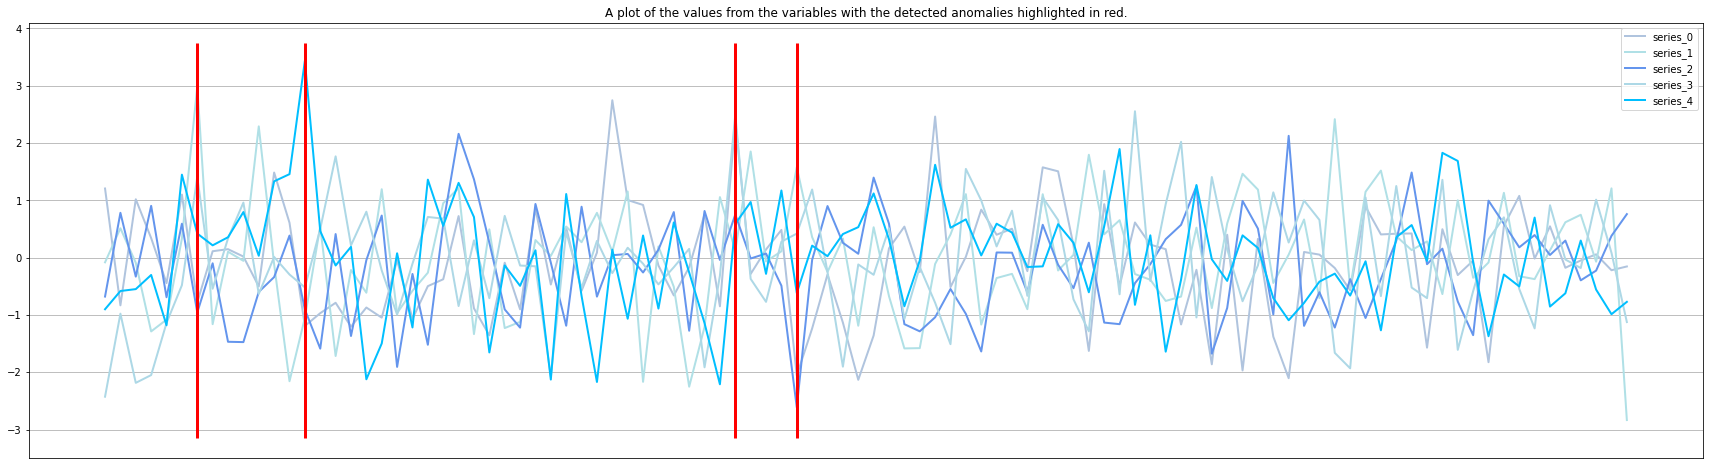

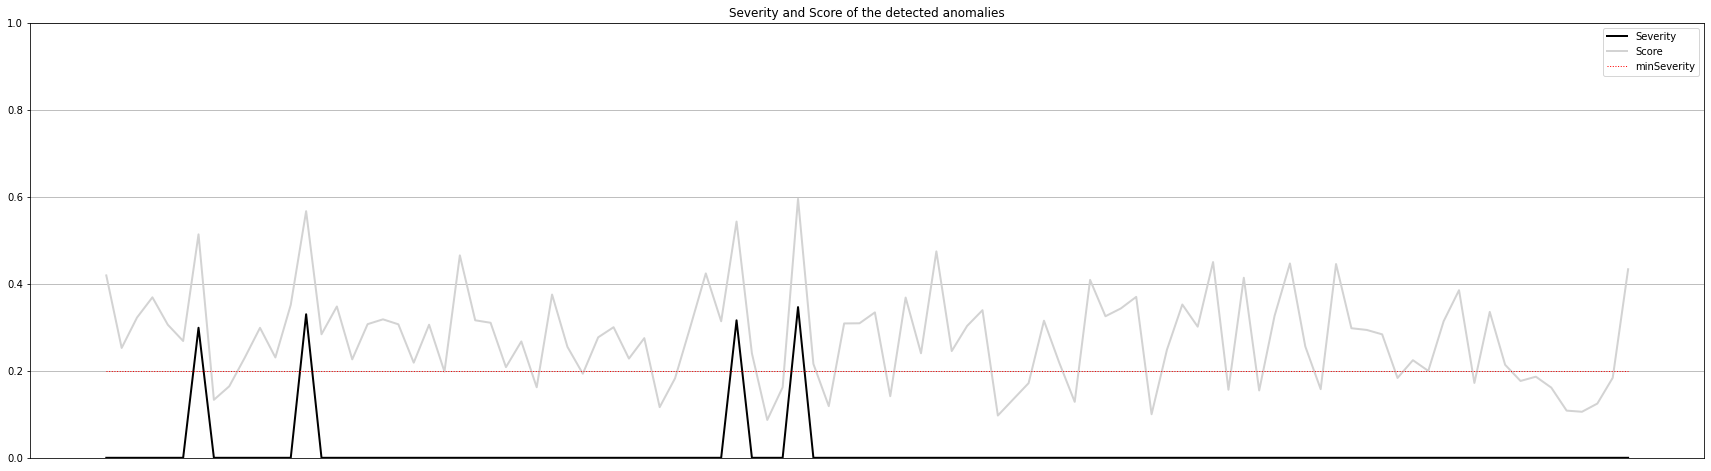

In [22]:
# You could use this parameter to sift out the anomalies, the less this number is, the more anomalies will be marked out.
minSeverity = 0.2

# Only presents first 100 rows to see clearer graph.
df = df_merge.iloc[:100]

####### Main Figure #######
plt.figure(figsize=(30,8))
plt.plot(df['timestamp'],df['series_0'], color='lightsteelblue', linestyle='solid', linewidth=2, label='series_0')
plt.plot(df['timestamp'],df['series_1'], color='powderblue', linestyle='solid', linewidth=2, label='series_1')
plt.plot(df['timestamp'],df['series_2'], color='cornflowerblue', linestyle='solid', linewidth=2, label='series_2')
plt.plot(df['timestamp'],df['series_3'], color='lightblue', linestyle='solid', linewidth=2, label='series_3')
plt.plot(df['timestamp'],df['series_4'], color='deepskyblue', linestyle='solid', linewidth=2, label='series_4')

plt.grid(axis='y')
plt.tick_params(axis='x',which='both',bottom=False,labelbottom=False)
plt.legend()

anoms = list(df["severity"] >= minSeverity)
_, _, ymin, ymax = plt.axis()
plt.vlines(np.where(anoms), ymin=ymin , ymax=ymax , color='r', alpha=1,linewidth=3)

plt.legend()
plt.title('A plot of the values from the variables with the detected anomalies highlighted in red.')
plt.show()


####### Severity Figure #######
plt.figure(figsize=(30,8))
plt.tick_params(axis='x',which='both',bottom=False,labelbottom=False)
plt.plot(df['timestamp'],df['severity'], color='black', linestyle='solid', linewidth=2, label='Severity')
plt.plot(df['timestamp'],df['score'], color='lightgrey', linestyle='solid', linewidth=2, label='Score')
plt.plot(df['timestamp'],[minSeverity]*len(df['severity']), color='red', linestyle='dotted', linewidth=1, label='minSeverity')
plt.grid(axis='y')
plt.legend()
plt.ylim((0,1))
plt.title("Severity and Score of the detected anomalies")
plt.show()

In [23]:
# Display only the anomalous timestamps.
df_anomaly = df[df['isAnomaly']== True]
df_anomaly

,timestamp,isAnomaly,severity,score,interpretation,series_0,series_1,series_2,series_3,series_4
6,2021-01-02T09:06:00Z,True,0.299029,0.513817,"[{'variable': 'series_1', 'contributionScore':...",-0.780282,2.986235,-0.957419,1.407516,0.419483
13,2021-01-02T09:13:00Z,True,0.330084,0.567177,"[{'variable': 'series_4', 'contributionScore':...",-1.192829,-1.049519,-0.904737,-0.519764,3.436035
41,2021-01-02T09:41:00Z,True,0.316140,0.543218,"[{'variable': 'series_3', 'contributionScore':...",2.386084,0.120218,0.752255,2.492716,0.588779
45,2021-01-02T09:45:00Z,True,0.346528,0.595433,"[{'variable': 'series_2', 'contributionScore':...",-2.056664,1.578338,-2.614383,0.418353,-0.618969


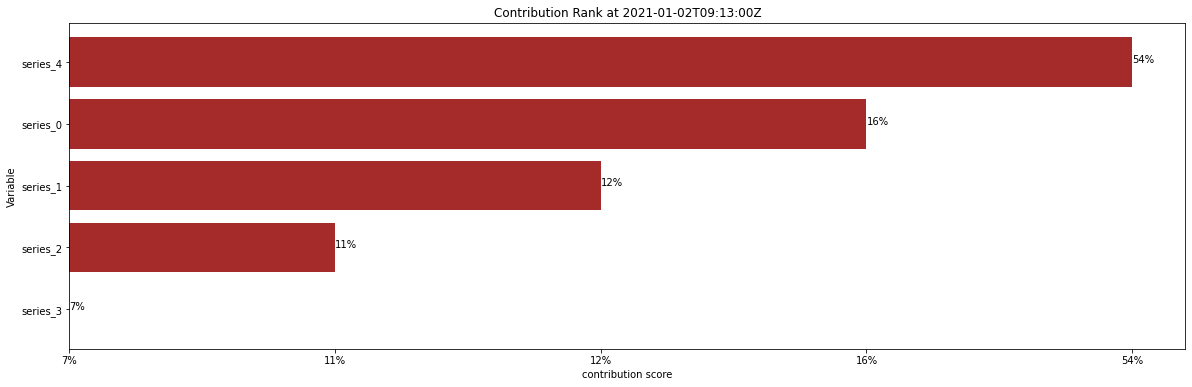

The last column indicates the correlated variables with the first column variable, whose correlations caused the anomaly.


,variable,contributionScore,correlationChanges.changedVariables
0,series_4,0.543004,[series_3]
1,series_0,0.155167,[series_3]
2,series_1,0.119975,[series_3]
3,series_2,0.113266,[series_3]
4,series_3,0.068589,[series_3]


In [24]:
from tkinter.font import BOLD
from turtle import color


anomaly_index = 1
d = df_anomaly.iloc[anomaly_index]['interpretation'][::-1]
timestamp = df_anomaly.iloc[anomaly_index]['timestamp']
correlatedVar = df_anomaly.iloc[anomaly_index]['interpretation']

x=[item.get('variable') for item in d]
y=[item.get('contributionScore') for item in d]
Z=[item.get('correlationChanges') for item in d]

l=[]
for i in y:
    i =  "%.f%%" % (i * 100)
    l.append(i)

plt.figure(figsize=(20,6))


plt.barh(x, l,color="brown",alpha=1)

for index, value in enumerate(l):
    plt.text(value, index,str(value) )

# setting label of y-axis
plt.ylabel("Variable")

# setting label of x-axis
plt.xlabel("contribution score")
plt.title("Contribution Rank at "+timestamp)

plt.show()
print("The last column indicates the correlated variables with the first column variable, whose correlations caused the anomaly.")
pd.json_normalize(correlatedVar)